# Single-belt transmission using two pulleys

This notebook reasons through the mathematics described in the "Gates" formulas in the FreeCAD forum thread at [Re: Modeling single-belt transmission using standard off-the-shelf v-belts and pulleys post 184520](https://forum.freecadweb.org/viewtopic.php?p=185286#p184520) to find a more precise value of center-to-center distance between the pulleys, given user-supplied length $L_p$ of the pulley, and both pitch diameters of both pulleys, $D$ and $d$.

This notebook with `scipy.optimize.root` to find the precise center-to-center distance, $C$.

Below, **Formula 3** and **Formula 4** are those formulas in the Gates PDF referenced by the above [forum post](https://forum.freecadweb.org/viewtopic.php?p=185286#p184520).

# Formula 3

The more precise Formula 3 is:

$$L_p = 2C \cos\varphi + \frac{\pi (D + d)}{2}  + \frac{\pi\varphi(D - d)}{180}$$

where:

- $L_p$ is belt pitch length, inches
- $C$ is center distance, inches
- $D$ is pitch diameter of large pulley, inches
- $d$ is pitch diameter of small pulley, inches
- $\varphi = \arcsin(\frac{D-d}{2C})$ and must be the same thing as $\phi$ in the diagram in the [forum post](https://forum.freecadweb.org/viewtopic.php?p=185286#p184520) right underneath **Formula 4** given the trig formula of $\sin(x) = \frac{opposite}{hypotenuse}$


Plot the right-hand side of Formula 3 to explore what it looks like. Ignore the left-hand side value of $L_p$ for the moment:

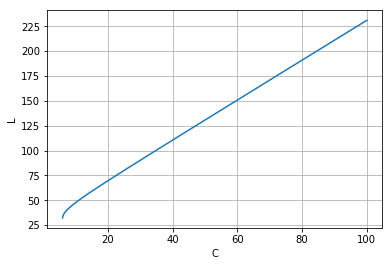

In [92]:
import math
import matplotlib.pyplot as plt  
import numpy as np 

def rhs_formula_3(C, D, d):
    """Right hand side of Formula 3 as a function of C, D, and d."""
    
    # diff is a helper, like phi:
    diff = D - d

    phi = np.arcsin(diff / (2 * C))

    # L is the vbelt length corresponding to C calculated via Formula 3:
    L = 2 * C * np.cos(phi) + ((math.pi * (D + d)) / 2) + (math.pi * phi * diff)/ 180

    return L

D = 16.0  # inches
d = 4.0  # inches
# L = 56  # inches
                                                             
C = np.linspace(0, 100, 1000)
L = rhs_formula_3(C, D, d)
plt.xlabel('C')
plt.ylabel('L')
plt.grid(True)
plt.plot(C, L)
plt.show()

This seems to be fairly linear with $C$ values greater than ~8. So in practice, for arbitrary user-supplied values of $L_p$, $D$, and $d$, we will need to do extra checks against invalid values.

# Formula 4

Formula 4 is the approximate center distance given values of $L_p$, $D$ and $d$:

$$C = \frac{K + \sqrt{K^2 - 32(D - d)^2}}{16}$$

where:

- $K = 4L_p - 2\pi(D - d)$

Plot the right hand side of Formula 4:

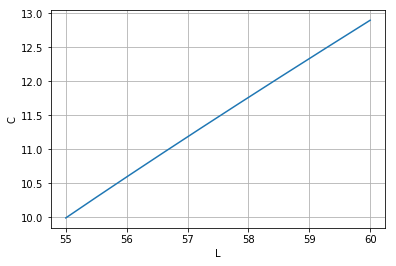

In [88]:
import math
import matplotlib.pyplot as plt
import numpy as np


def rhs_formula_4(L, D, d):
    """Right hand side of Formula 4 as a function of L, D, and d."""

    K = (4 * L) - (2 * math.pi * (D + d))
    C = (K + np.sqrt(np.power(K, 2) - (32 * np.power(D - d, 2)))) / 16
    return C


D = 16.0  # inches
d = 4.0  # inches
# L = 56  # inches

L = np.linspace(55, 60, 1000)
C = rhs_formula_4(L, D, d)
plt.xlabel('L')
plt.ylabel('C')
plt.grid(True)
plt.plot(L, C)
plt.show()

# Formula 3r

("r" for rearranged, or for roots)

For our application, the belt length, $L_p$, is a given, and we want to know a (fairly?) precise value of $C$. So taking Formula 3 and rearranging:

$$0 = 2C \cos\varphi + \frac{\pi (D + d)}{2}  + \frac{\pi\varphi(D - d)}{180} - L_p$$

We have a non-linear formula. The value (values?) of $C$ are the roots of that equation.


First, we plot the right-hand side of the above rearranged formula:

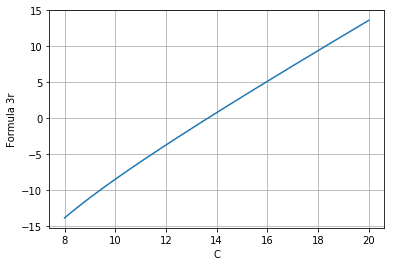

In [14]:
import math
import matplotlib.pyplot as plt  
import numpy as np 

def rhs_formula_3r(C, L, D, d):
    """Formula 3 rearranged to be a function that can be passed eventually to optimize.root,
    as a function of C, L, D, and d."""
    
    # diff is a helper, like phi:
    diff = D - d

    phi = np.arcsin(diff / (2 * C))

    # L is the vbelt length corresponding to C calculated via Formula 3:
    return 2 * C * np.cos(phi) + ((math.pi * (D + d)) / 2) + (math.pi * phi * diff)/ 180 - L


D = 16.0  # inches
d = 4.0  # inches
L = 56  # inches
                                                             
C = np.linspace(8, 20, 1000)
L = rhs_formula_3r(C, L, D, d)
plt.xlabel('C')
plt.ylabel('Formula 3r')
plt.grid(True)
plt.plot(C, L)
plt.show()

So there seems to be a root of $C$ somewhere between 12 and 14 inches.

Now we can apply [scipy.optimize.root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html#scipy.optimize.root).

But that requires an initial guess (the `x0` argument of the `optimize.root` function).  If we plot larger and larger values of the `rhs_formula_3r` function above, we see it is monotonically increasing, so we can guess that we can give it some rather large value for $C$ for the starting value and the `optimize.root` function should easily find the root.

So our starting value could actually be close to $L_p$ of our known v-belt length of 56 inches, and we know that the precise value of $C$ we are looking for should be less than that, just given the geometrical constraints.

There are many other options to pass to `optimize.root`, but the defaults seemed to work (see read on).

In [98]:
import math
import numpy as np
from scipy import optimize

def rhs_formula_3r(C, L, D, d):
    """Formula 3 rearranged to be a function that can be passed to scipi.optimize.root,
    as a function of C, L, D, and d."""
    
    # diff is a helper, like phi:
    diff = D - d

    phi = np.arcsin(diff / (2 * C))

    # L is the vbelt length corresponding to C calculated via Formula 3:
    return 2 * C * np.cos(phi) + ((math.pi * (D + d)) / 2) + (math.pi * phi * diff)/ 180 - L


D = 16.0  # inches
d = 4.0  # inches
L = 56  # inches

# We know that the center distance, by physical geometrical constraints, 
# must be less than L, so we just start the initial guess at that value, of L:
C_guess = L

def rhs_formula_3r_with_fixed_L(C):
    return rhs_formula_3r(C, L, D, d)

result = optimize.root(rhs_formula_3r_with_fixed_L, C_guess)
C_found = result.x[0]
print "Found C: {}".format(C_found)


Found C: 13.6353746387


Redo the above plot of `rhs_formula_3r` but "zoom in" by changing the arguments to the `np.linspace` call to see the root:

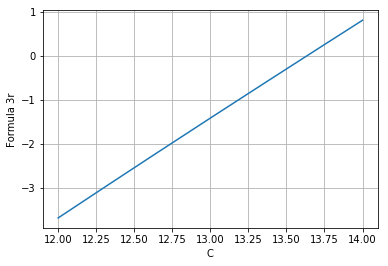

In [1]:
import math
import matplotlib.pyplot as plt  
import numpy as np 

def rhs_formula_3r(C, L, D, d):
    """Formula 3 rearranged to be a function that can be passed eventually to optimize.root,
    as a function of C, L, D, and d."""
    
    # diff is a helper, like phi:
    diff = D - d

    phi = np.arcsin(diff / (2 * C))

    # L is the vbelt length corresponding to C calculated via Formula 3:
    return 2 * C * np.cos(phi) + ((math.pi * (D + d)) / 2) + (math.pi * phi * diff)/ 180 - L


D = 16.0  # inches
d = 4.0  # inches
L = 56  # inches
                                                             
C = np.linspace(12, 14, 1000)
L = rhs_formula_3r(C, L, D, d)
plt.xlabel('C')
plt.ylabel('Formula 3r')
plt.grid(True)
plt.plot(C, L)
plt.show()

Plug in the value of `C_found` to our precise Formula 3 function to verify what is returned matches up with our originally supplied value of $L_p$:

In [91]:
D = 16.0  # inches
d = 4.0  # inches
# L = 56  # inches

L = rhs_formula_3(C_found, D, d)
print "Calculated L: {}".format(L)

Calculated L: 56.0


And it does.

But it is interesting that, up to right now, we did not even use **Formula 4** at all. We didn't even need it for this use case where the user starts out with a chosen v-belt, and thus a fixed value of the length of that v-belt, $L_p$.

For chuckles, plug the value for $L_p$ into **Formula 4** to see what it calculates:

In [97]:
D = 16.0  # inches
d = 4.0  # inches
L = 56  # inches

C_from_formula_4 = rhs_formula_4(L, D, d)
C_from_formula_4


10.592763440293096

which is pretty far off from `C_found`. 

# Formula chrisb

Let's analyze the formula chrisb (thanks Chris!) at his [forum post](https://forum.freecadweb.org/viewtopic.php?p=185286#p184566):

His formula is:

$$L = 2\sqrt{a^2 - (R - r)^2} + \pi(R + r) + 2\pi\frac{\arcsin{\frac{R-r}{a}}}{180}(R - r)$$

where:

- $L$ is the same as our earlier $L_p$
- $a$ is the same as our earlier $C$
- $R$ is the radius of the big pulley which is the same as $D/2$
- $r$ is the radius of the small pulley which is the same as $d/2$



Re-express it using our earlier symbols:

# Formula chrisb2

** Formula chrisb** reexpressed using our earlier symbols is:

$$L_p = 2\sqrt{C^2 - (\frac{D - d}{2})^2} + \frac{\pi(D + d)}{2} + \frac{\pi\varphi(D - d)}{180}$$

where:

$$\varphi = \arcsin{\frac{D - d}{2C}}$$

Compare to the **Formula 3** which was:

$$L_p = 2C \cos\varphi + \frac{\pi (D + d)}{2}  + \frac{\pi\varphi(D - d)}{180}$$




It seems that **Formula chrisb2** which we derived above seems awfully close to **Formula 3**. Let's do a quick plot of the differences between them to see how far apart they are:

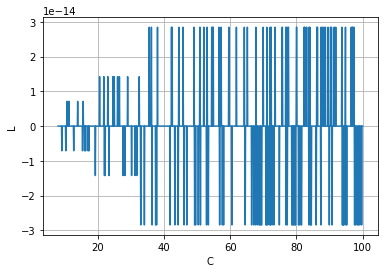

In [23]:
import math
import matplotlib.pyplot as plt
import numpy as np


def rhs_formula_3(C, D, d):
    """Right hand side of Formula 3 as a function of C, D, and d."""

    # diff is a helper, like phi:
    diff = D - d

    phi = np.arcsin(diff / (2 * C))

    # L is the vbelt length corresponding to C calculated via Formula 3:
    L = 2 * C * np.cos(phi) + ((math.pi * (D + d)) / 2) + (math.pi * phi * diff) / 180

    return L


def rhs_formula_chrisb2(C, D, d):
    """Right hand side of Formula chrisb2 as a function of C, D, and d."""

    # diff is a helper, like phi:
    diff = D - d

    phi = np.arcsin(diff / (2 * C))

    # L is the vbelt length corresponding to C calculated via Formula chrisb2:
    L = 2 * np.sqrt(np.power(C, 2) - np.power(diff / 2, 2)) + ((math.pi * (D + d)) / 2) + (math.pi * phi * diff) / 180

    return L


D = 16.0  # inches
d = 4.0  # inches
# L = 56  # inches

C = np.linspace(8, 100, 1000)
L_3 = rhs_formula_3(C, D, d)
L_chrisb2 = rhs_formula_chrisb2(C, D, d)
L_diff = L_chrisb2 - L_3
plt.xlabel('C')
plt.ylabel('L')
plt.grid(True)
plt.plot(C, L_diff)
plt.show()


Given the extremely small differences in `L_diff` shown above (floating point error no doubt), I conclude **Formula 3** and **Formula chrisb2** (and thus chrisb's original formula) are equivalent.

So switching to use his formula might not provide any benefit, per se (unless his is more efficient which might be relevant to investigate at some other time).



# Why is convergence between Formula 3 and Formula 4 required?

The Gates PDF stated that Formula 4 needed to converge with Formula 3:

> The exact center distance can be calculated using an iterative
> process between the center distance (Formula 4) and belt
> length (Formula 3) equations. The exact center distance has
> been found when the two equations converge.

Why isn't **Formula 3** sufficient?  It might not be. Read on.

# Model the pulley in FreeCAD

Along in the original post, I had modeled the pulley in FreeCAD. Find that in this same directory named as [single_belt_transmission.fcstd](single_belt_transmission.fcstd).

Inside FreeCAD file, I have constrained the sketch that models the pulley to have the dimensions we found, and applied the [total_sketcher_geometry_length.py](total_sketcher_geometry_length.py) to measure all lengths of all non-construction geometry which should be the real v-belt length. We found it gave a value of 1.70 yd or around 61.2 inches which is not our starting value of 56 inches for length.

What would be the cause of this difference? Both **Formula chrisb** and **Formula 3** seem to be equivalent as shown above.

Does this indicate a need for that "iterative process" indicated above, or something wrong in how I constructed the FreeCAD document?
